<a href="https://colab.research.google.com/github/beccashamus23/CC_object_removal/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction #

Our goal is to create a code that will seperate overly obstructed images from useable images. From here the useable images will go through a processing that will remove the obstruction by using a machine learning algorithm that uses the neighboring pixels to "fill in" the gaps left by that obstruction

# Step 1: Determining obstructed vs useable images #

The first step of processing the image is taking the input image and determine if it is useable or not. To do this we began by thresholding the image, color coding each aspect [using this key](https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit?usp=sharing). 

The clouds and sky are categorized by the color (6, 230, 230). To determine if the image was useable, we calculated what percentage of the image was sky/clouds (had the same color code). We determined that if an image was  < 60% sky/clouds, it was too obstructed.

To color code the images we used [this repository](https://github.com/CSAILVision/semantic-segmentation-pytorch)

The images that were too obstructed were "flagged." This was done by placing the obstructed and useable images into two seperate folders, the flagged images were not used for future processing.

The predicted image is then passed into the next step for further processing

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

if (os.path.isfile("/content/project_folder") == False):
    %mkdir project_folder

Mounted at /content/drive


In [ ]:
%%bash
# installs github used for color thresholding
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [ ]:
def color_segmentation(img_path):
  # System libs
  import os, csv, torch, scipy.io, PIL.Image, torchvision.transforms
  import numpy as np
  from PIL import Image
  import cv2
  from google.colab.patches import cv2_imshow
  from pathlib import WindowsPath

  # Our libs
  from mit_semseg.models import ModelBuilder, SegmentationModule
  from mit_semseg.utils import colorEncode

  colors = scipy.io.loadmat('data/color150.mat')['colors']
  names = {}
  with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
      names[int(row[0])] = row[5].split(";")[0]

    def visualize_result(img, pred, index=None):
    # filter prediction class if requested
      if index is not None:
          pred = pred.copy()
          pred[pred != index] = -1
          print(f'{names[index+1]}:')
        
    # colorize prediction
      pred_color = colorEncode(pred, colors).astype(np.uint8)
      return PIL.Image.fromarray(pred_color)

  net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
  net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

  crit = torch.nn.NLLLoss(ignore_index=-1)
  segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
  segmentation_module.eval()
  segmentation_module.cuda()

  # Load and normalize one image as a singleton tensor batch
  pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
  ])
  pil_image = PIL.Image.open(img_path).convert('RGB')

  display(pil_image)
  
  img_original = np.array(pil_image)
  img_data = pil_to_tensor(pil_image)
  singleton_batch = {'img_data': img_data[None].cuda()}
  output_size = img_data.shape[1:]

    # Run the segmentation at the highest resolution.
  with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
    # Get the predicted scores for each pixel
  _, img_path = torch.max(scores, dim=1)
  img_path = img_path.cpu()[0].numpy()

  pred_img = visualize_result(img_original, img_path)
  
  # reshape image and save
  # pred_img_arr = np.array(pred_img)[64:700, 64:700]
  # pred_img = Image.fromarray(pred_img_arr)

  #save predicted images
  pred_img = pred_img.save("/content/predicted_images/predicted.png")

  # sky code: (6, 230, 230)
  img_arr = cv2.imread("/content/predicted_images/predicted.png")

  # correct color
  img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img_arr)

  # count sky clue pixels
  BLUE = np.array([6, 230, 230], np.uint8)
  blue_pix = np.sum(img_arr == BLUE)
  size = np.size(img_arr)

  display(img)

  percent = np.round(((blue_pix/size) * 100), 2)
  # print percentage
  print("%s%%"%percent)
  
  if(percent < 60):
    img = img.save("/content/obstructed/predicted.png")
  else:
    img = img.save("/content/useable/predicted.png")

# Step 2: Creating the mask #

This step is where most of the image processing is happening.
1. The first step in create mask changes all the pixels to black and white depending on if they are sky/clouds or obstruction in our predicted image mask. This produces the binary mask. 
2. Next, we want all black (sky/cloud) pixels to be transparent. Why? Because the model wants the image mask to look like the original image, with white covering the parts of the image you want the model to predict
3. After, we lay the white mask with the transparent background over the original image
4. finally we adjust the image shape and resolution, this allows for the model to produce the most accurate results

In [ ]:
%cd /content/project_folder
!git clone https://github.com/knazeri/edge-connect.git

/content/project_folder
Cloning into 'edge-connect'...
remote: Enumerating objects: 439, done.
remote: Total 439 (delta 0), reused 0 (delta 0), pack-reused 439
Receiving objects: 100% (439/439), 1.34 MiB | 8.19 MiB/s, done.
Resolving deltas: 100% (266/266), done.


In [ ]:
def create_mask(img_path, predicted_img_path):
  import cv2, os
  import numpy as np
  from PIL import Image, ImageChops

  # creates black and white mask

  mask_arr = cv2.imread(predicted_img_path)
  mask_arr = cv2.cvtColor(mask_arr, cv2.COLOR_BGR2GRAY)

  # changes all sky pixels to black

  mask=cv2.inRange(mask_arr,150, 180)
  mask_arr[mask>0] = 0

  # changes all pixels above and below sky mask to white

  mask=cv2.inRange(mask_arr,1, 149)
  mask_arr[mask>0] = 255

  mask=cv2.inRange(mask_arr,180, 255)
  mask_arr[mask>0] = 255

  mask_img = Image.fromarray(mask_arr)
  %cd /content
  mask_img = mask_img.save("/content/project_folder/edge-connect/examples/places2/masks/ourmask.png")
  mask_img = cv2.imread("/content/project_folder/edge-connect/examples/places2/masks/ourmask.png")

  # creates transparent mask

  mask_img = Image.fromarray(mask_arr).convert("RGBA")
  pixdata = mask_img.load()

  width, height = mask_img.size

  for y in range(height):
      for x in range(width):
          if pixdata[x, y] == (0, 0, 0, 255):
              pixdata[x, y] = (255, 255, 255, 0)

  %cd /content/project_folder/edge-connect/examples/places2/

  if (os.path.isfile("/content/project_folder/edge-connect/examples/places2/images_nomask") == False):
    %mkdir images_nomask

  %cd /content
  original_img = Image.open(img_path)

  original_img = original_img.save("/content/project_folder/edge-connect/examples/places2/images_nomask/originalimg.png")

  # lays transparent over original image
  %cd /content/project_folder/edge-connect/examples/places2/images_nomask/
  
  background = Image.open("/content/project_folder/edge-connect/examples/places2/images_nomask/originalimg.png").convert("RGBA")

  img_with_mask = Image.new("RGBA", background.size)
  img_with_mask = Image.alpha_composite(background, background)
  img_with_mask = Image.alpha_composite(img_with_mask, mask_img)

  # adjust mask size and shape
  mask_arr = np.array(mask_img)[0:636, 0:636,3]
  mask_img = Image.fromarray(mask_arr)
  mask_img = mask_img.save("/content/project_folder/edge-connect/examples/places2/masks/img_mask.png")

  %cd /content/project_folder/edge-connect/examples/places2/images

  # adjust input image size and shape

  img_with_mask_array = np.array(img_with_mask)
  img_with_mask_array = cv2.cvtColor(img_with_mask_array, cv2.COLOR_RGBA2RGB)
  img_with_mask_array = img_with_mask_array[0:636,0:636,:]
  img_with_mask = Image.fromarray(img_with_mask_array)

  # change image and resolution
  img_with_mask = img_with_mask.resize((256, 256), Image.ANTIALIAS)

  # save image to mask folder
  img_with_mask = img_with_mask.save("img_with_mask.png")

# Step 3: Evaluating with the pretrained model #

This is the section of the code that trains the model, the training methodology can be found [here](https://github.com/knazeri/edge-connect). In the train_model method, we are copying the training files to our project folder and giving the model the checkpoints, input (original) images, the image masks we created, and specifying where to place the trained images

In [ ]:
!pip install scipy==1.1.0
%cd /content/project_folder/edge-connect
!python3 "/content/project_folder/edge-connect/test.py"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/project_folder/edge-connect
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

start testing...


End test....


In [ ]:
%%bash

DIR='./checkpoints'
URL='https://drive.google.com/uc?export=download&id=1IrlFQGTpdQYdPeZIEgGUaSFpbYtNpekA'

echo "Downloading pre-trained models..."
mkdir -p $DIR
FILE="$(curl -sc /tmp/gcokie "${URL}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')" 
curl -Lb /tmp/gcokie "${URL}&confirm=$(awk '/_warning_/ {print $NF}' /tmp/gcokie)" -o "$DIR/${FILE}" 

echo "Extracting pre-trained models..."
cd $DIR
unzip $FILE
rm $FILE

echo "Download success."

Extracting pre-trained models...
Archive:  models.zip
Download success.


awk: cannot open /tmp/gcokie (No such file or directory)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2369    0  2369    0     0  19578      0 --:--:-- --:--:-- --:--:-- 19741
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of models.zip or
        models.zip.zip, and cannot find models.zip.ZIP, period.


In [ ]:
def train_model():
  if os.path.isfile("/content/project_folder/edge-connect/datasets") == False:
    %mkdir datasets

  !cp "/content/drive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Training Edge Connect/EdgeModel_dis.pth" "/content/project_folder/edge-connect/checkpoints"
  !cp "/content/drive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Training Edge Connect/EdgeModel_gen.pth" "/content/project_folder/edge-connect/checkpoints"
  !cp "/content/drive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Training Edge Connect/InpaintingModel_dis.pth" "/content/project_folder/edge-connect/checkpoints"
  !cp "/content/drive/Shareddrives/FIRE-CC/Summer Interns/Obstructions in Photos/Training Edge Connect/InpaintingModel_gen.pth" "/content/project_folder/edge-connect/checkpoints"
  !python ./scripts/flist.py --path path_to_places2_train_set --output ./datasets/places_train.flist
  !python train.py --model 1 --checkpoints ./checkpoints/places2

  %cd /content/project_folder/edge-connect
  !python test.py \
    --model  3 \
    --checkpoints /content/project_folder/edge-connect/checkpoints \
    --input /content/project_folder/edge-connect/examples/places2/images \
    --mask  /content/project_folder/edge-connect/examples/places2/masks \
    --output /content/project_folder/edge-connect/checkpoints/results

# Step 4: The main method #

What this method does is create the folders for obstructed and useable images, along with other folders that will be used to store images.
The main method will call the methods from all the other steps, each step passes the image through different processing to display the final result

In [ ]:
import os
def create_folders():
  if (os.path.isfile("/content/predicted_images") == False):
    %mkdir predicted_images

  if (os.path.isfile("/content/obstructed") == False):
    %mkdir obstructed

  if (os.path.isfile("/content/useable") == False):
    %mkdir useable

/content
mkdir: cannot create directory ‘predicted_images’: File exists
mkdir: cannot create directory ‘obstructed’: File exists
mkdir: cannot create directory ‘useable’: File exists
Loading weights for net_encoder
Loading weights for net_decoder


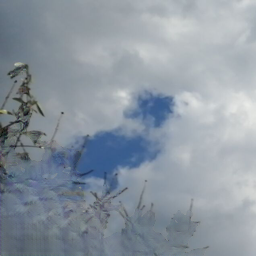

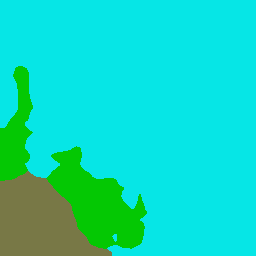

79.51%
/content
/content/project_folder/edge-connect/examples/places2
mkdir: cannot create directory ‘images_nomask’: File exists
/content
/content/project_folder/edge-connect/examples/places2/images_nomask
/content/project_folder/edge-connect/examples/places2/images
mkdir: cannot create directory ‘datasets’: File exists
python3: can't open file './scripts/flist.py': [Errno 2] No such file or directory
python3: can't open file 'train.py': [Errno 2] No such file or directory
/content/project_folder/edge-connect
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed i

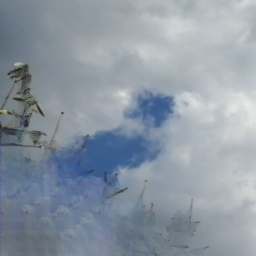

In [ ]:
from PIL import Image
import io

def main(img_path):
  create_folders()
  color_segmentation(img_path=img_path)
  create_mask(img_path, "/content/useable/predicted.png")
  train_model()
  img = Image.open("/content/project_folder/edge-connect/checkpoints/results/img_with_mask.png")
  return img

%cd /content
main("/content/Unknown-2.png")

After running each code cell, copy and paste the image path into the main method and run!